# HomographyNet

## Table of Contents
1. Dataset Generation
 1. [Initial processing of samples](#Initial-processing-of-samples)
 2. [Generation of patches and perturbations](#Generation-of-patches-and-perturbations)
 3. [Training data preparation](#Training-data-preparation)
2. Model Implementation
 1. [Training](#Training)
3. Experiments
 1. [A better model based on the MobileNet architecture](#A-better-model-based-on-the-MobileNet-architecture)
 2. [Visualization of predictions](#Visualization-of-predictions)

In [29]:
import sys
# Hack to make our modules visible
sys.path.append("../")

import matplotlib.pyplot as plt
import cv2
import numpy as np
import json

import demo_utils

# Copied from CS231n exercises:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial processing of samples

Images from the COCO 2017 validation (5k images) and test (~41k images) sets were used to generate the training data. 12 samples were generated from each image for a total of ~551k image pairs and labels. 500k of the samples were used for training while the remaining ~51k were used for validation.

1. Conversion from RGB to grayscale.
2. Scale to 320x240 (best fit?)
3. Center crop to 320x240

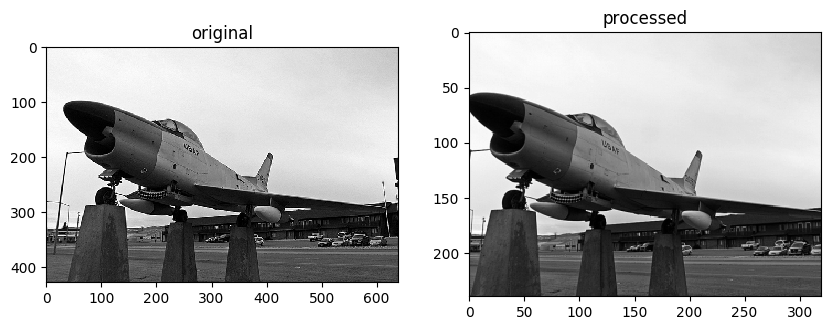

In [43]:
img_file = '000000084752.jpg' # or '000000111006.jpg'
target_size = (320, 240)
patch_size = (128, 128)

# Load
img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(10, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set(title='original')

# Scale and crop
img = demo_utils.scale_down(img, target_size)
img = demo_utils.center_crop(img, target_size)

ax[1].imshow(img, cmap='gray')
ax[1].set(title='processed')

plt.show()

## Generation of patches and perturbations
1. Generate random coordinates for 128x128 patch
2. Add random perturbations (p = 32)
3. Crop original image
4. Warp, then crop warped image

In [44]:
# Sample 128x128 patches
p_original, p_perturbed = demo_utils.generate_points()

# Warp and draw bounding boxes for visualization
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb = demo_utils.draw_lines(img_rgb, p_original, (0, 0, 255), 1)
img_rgb = demo_utils.draw_lines(img_rgb, p_perturbed, (0, 255, 0), 1)
img_rgb_warped = demo_utils.warp(img_rgb, p_original, p_perturbed, target_size)

img_warped = demo_utils.warp(img, p_original, p_perturbed, target_size)

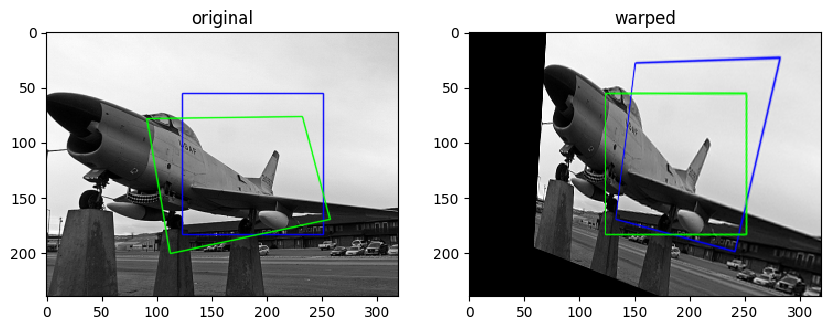

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(10, 10))
ax[0].imshow(img_rgb, cmap='gray')
ax[0].set(title='original')

ax[1].imshow(img_rgb_warped, cmap='gray')
ax[1].set(title='warped')

plt.show()

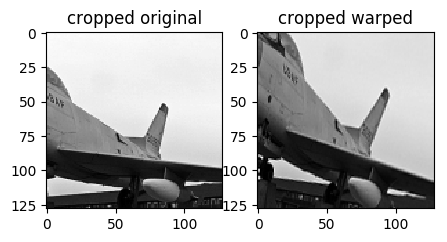

In [46]:
patch_img = demo_utils.crop(img, p_original[0], patch_size)
patch_img_warped = demo_utils.crop(img_warped, p_original[0], patch_size)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(5, 5))
ax[0].imshow(patch_img, cmap='gray')
ax[0].set(title='cropped original')

ax[1].imshow(patch_img_warped, cmap='gray')
ax[1].set(title='cropped warped')

plt.show()

## Training data preparation
1. Image pairs are stacked channel-wise to get a (128, 128, 2) tensor
2. Subtract the original points from the perturbed ones to get the offsets, then flatten to get an 8-D vector
3. A preprocessing step is used to normalize both the sample (image pair) and label (offsets) to have a mean of 0 and a variance of 1.

In [47]:
sample = np.stack((patch_img, patch_img_warped), axis=-1)
sample.shape

(128, 128, 2)

In [48]:
gt_offsets = (p_perturbed - p_original).flatten()
print(gt_offsets)
print(gt_offsets.shape)

[-32  23 -19  21   6 -14 -11  17]
(8,)


In [ ]:
# Preprocess
sample = (sample - 127.5) / 127.5
gt_offsets = gt_offsets / 32.

## Training

In [49]:
from homographynet.models import create_model
model_baseline = create_model(use_weights=True)
model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
__________

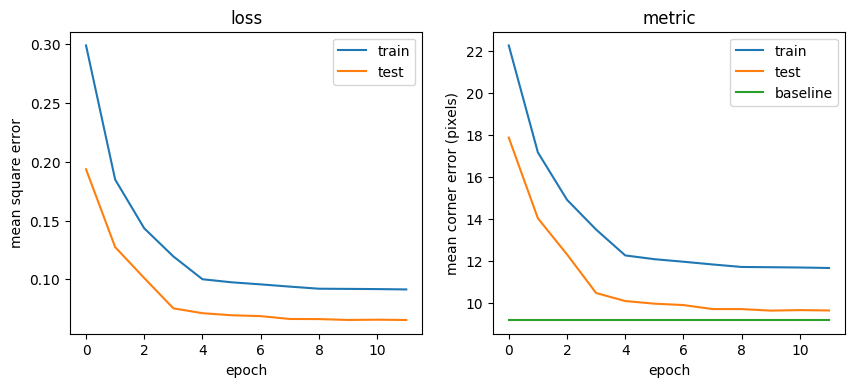

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(10, 4))
with open('training-history-baseline.json', 'r') as f:
    history_baseline = json.load(f)

ax[0].plot(history_baseline['loss'])
ax[0].plot(history_baseline['val_loss'])
ax[0].set_title('loss')
ax[0].set_ylabel('mean square error')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper right')

h1 = np.array(history_baseline['mean_corner_error']) * 32
h2 = np.array(history_baseline['val_mean_corner_error']) * 32
ax[1].plot(h1)
ax[1].plot(h2)
ax[1].plot([0, 11], [9.2, 9.2])
ax[1].set_title('metric')
ax[1].set_ylabel('mean corner error (pixels)')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test', 'baseline'], loc='upper right')

plt.show()

In [50]:
prediction_baseline = model_baseline.predict_on_batch(sample[np.newaxis])

In [51]:
np.square(prediction_baseline - gt_offsets).mean()

0.022608593106924653

In [52]:
demo_utils.mean_corner_error(gt_offsets, prediction_baseline).squeeze() * 32

6.1571989653545707

## A better model based on the MobileNet architecture
A MobileNet-based model was trained with the exact same pipeline (iterations, training data, etc.) except for the optimizer. In this case, Adam (default config) was used instead of SGD. Its number of parameters is an order of magnitude lower (3.36M vs 34.20M).

In [53]:
from homographynet.models import create_mobilenet_model
model_mobilenet = create_mobilenet_model(True)
mnet.summary()

/home/darwin/virtualenvs/keras/lib/python3.6/site-packages/keras/applications/imagenet_utils.py:123: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 2)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 64, 64, 32)    576         input_1[0][0]                    
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 64, 64, 32)    128         conv1[0][0]                      
____________________________________________________________________________________________________
conv1_relu (Activation)          (None, 64, 64, 32)    0           conv1_bn[0][0]                   
___________________________________________________________________________________________

![MobileHomographyNet](mobile-model-top.png)

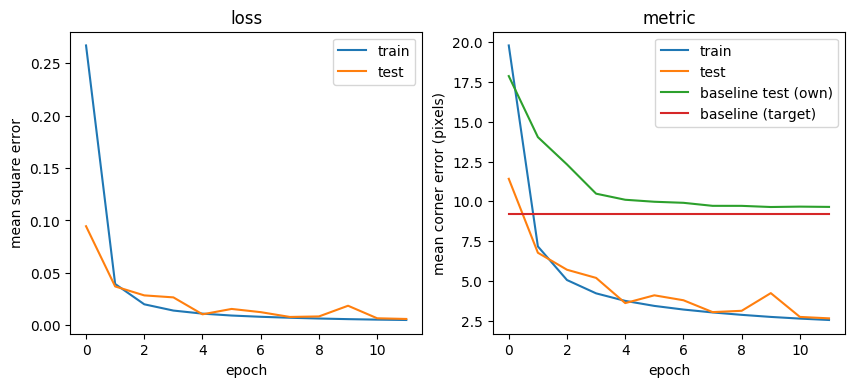

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(10, 4))
with open('training-history-mobilenet.json', 'r') as f:
    history = json.load(f)

ax[0].plot(history['loss'])
ax[0].plot(history['val_loss'])
ax[0].set_title('loss')
ax[0].set_ylabel('mean square error')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper right')

h1 = np.array(history['mean_corner_error']) * 32
h2 = np.array(history['val_mean_corner_error']) * 32
h3 = np.array(history_baseline['val_mean_corner_error']) * 32
ax[1].plot(h1)
ax[1].plot(h2)
ax[1].plot(h3)
ax[1].plot([0, 11], [9.2, 9.2])
ax[1].set_title('metric')
ax[1].set_ylabel('mean corner error (pixels)')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test', 'baseline test (own)', 'baseline (target)'], loc='upper right')

plt.show()

In [54]:
prediction_mobilenet = model_mobilenet.predict_on_batch(sample[np.newaxis])
np.square(prediction_mobilenet - gt_offsets).mean()

0.0013248880894156934

In [55]:
demo_utils.mean_corner_error(gt_offsets, prediction_mobilenet).squeeze() * 32

1.5313568239691622

## Visualization of predictions

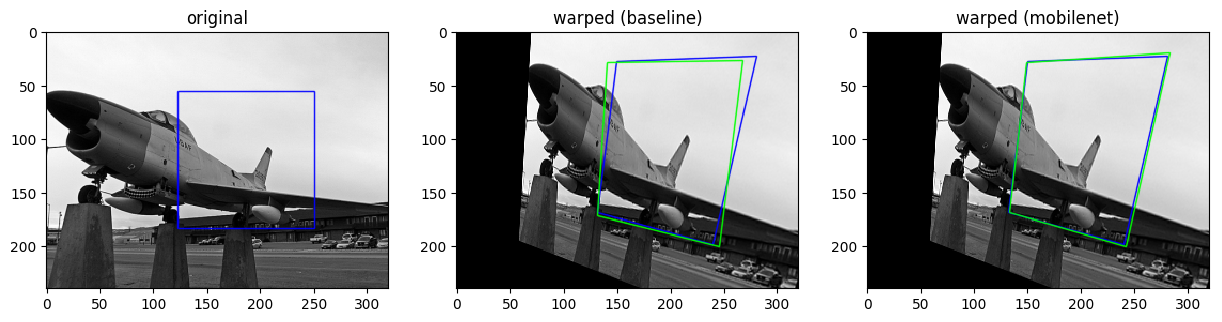

In [57]:
p_predicted = (p_original + prediction_baseline.reshape(4, 2) * 32).astype('uint16')
p_predicted_mnet = (p_original + prediction_mobilenet.reshape(4, 2) * 32).astype('uint16')

img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb_orig = demo_utils.draw_lines(img_rgb, p_original, (0, 0, 255), 1)

fig, ax = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(15, 15))
ax[0].imshow(img_rgb_orig, cmap='gray')
ax[0].set(title='original')


img_rgb_warped = demo_utils.warp(img_rgb, p_original, p_perturbed, target_size)

gt = demo_utils.transform_points(p_original, p_perturbed)
pred = demo_utils.transform_points(p_original, p_predicted)

img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, gt, (0, 0, 255), 1)
img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, pred, (0, 255, 0), 1)

ax[1].imshow(img_rgb_warped, cmap='gray')
ax[1].set(title='warped (baseline)')


img_rgb_warped = demo_utils.warp(img_rgb, p_original, p_perturbed, target_size)

pred = demo_utils.transform_points(p_original, p_predicted_mnet)

img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, gt, (0, 0, 255), 1)
img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, pred, (0, 255, 0), 1)

ax[2].imshow(img_rgb_warped, cmap='gray')
ax[2].set(title='warped (mobilenet)')

plt.show()

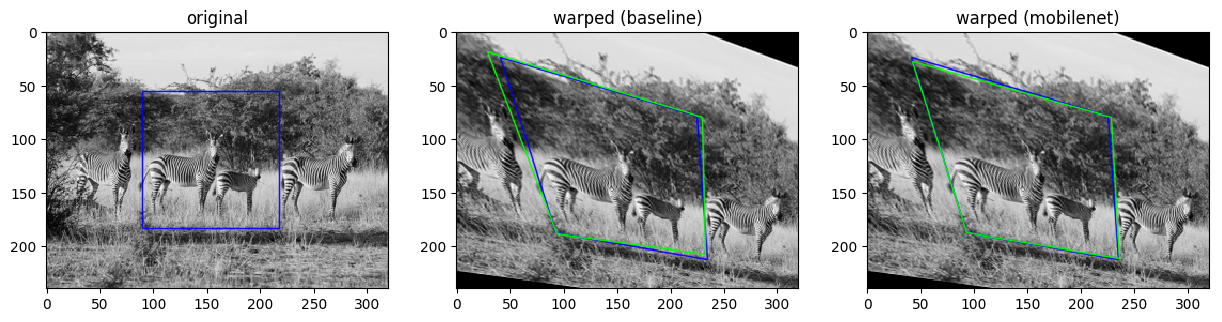

In [29]:
 # Load
img_path = '000000111006.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Scale and crop
img = demo_utils.scale_down(img, target_size)
img = demo_utils.center_crop(img, target_size)

p_original, p_perturbed = demo_utils.generate_points()
a = demo_utils.crop(img, p_original[0], patch_size)
b = demo_utils.warp(img, p_original, p_perturbed, target_size)
b = demo_utils.crop(b, p_original[0], patch_size)
sample = np.stack((a, b), axis=-1)
gt_offsets = (p_perturbed - p_original).reshape(-1)

# Preprocess
sample = (sample - 127.5) / 127.5
gt_offsets = gt_offsets / 32.

prediction_baseline = model_baseline.predict_on_batch(sample[np.newaxis])
prediction_mobilenet = model_mobilenet.predict_on_batch(sample[np.newaxis])

p_predicted = (p_original + prediction_baseline.reshape(4, 2) * 32).astype('int')
p_predicted_mnet = (p_original + prediction_mobilenet.reshape(4, 2) * 32).astype('int')

img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb_orig = demo_utils.draw_lines(img_rgb, p_original, (0, 0, 255), 1)

fig, ax = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(15, 15))
ax[0].imshow(img_rgb_orig, cmap='gray')
ax[0].set(title='original')


img_rgb_warped = demo_utils.warp(img_rgb, p_original, p_perturbed, target_size)

gt = demo_utils.transform_points(p_original, p_perturbed)
pred = demo_utils.transform_points(p_original, p_predicted)

img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, gt, (0, 0, 255), 1)
img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, pred, (0, 255, 0), 1)

ax[1].imshow(img_rgb_warped, cmap='gray')
ax[1].set(title='warped (baseline)')


img_rgb_warped = demo_utils.warp(img_rgb, p_original, p_perturbed, target_size)

pred = demo_utils.transform_points(p_original, p_predicted_mnet)

img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, gt, (0, 0, 255), 1)
img_rgb_warped = demo_utils.draw_lines(img_rgb_warped, pred, (0, 255, 0), 1)

ax[2].imshow(img_rgb_warped, cmap='gray')
ax[2].set(title='warped (mobilenet)')

plt.show()